# Modelling the Sentiment Analysis + Interpretation

## 1. Necessary Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, roc_curve
import shap
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
import config
from utils import load_processed_data, save_processed_data, print_section_header, setup_plotting_style, save_figure, statistical_comparison

## 2. Data Loading

In [2]:
# Load data from previous notebooks
df = load_processed_data('sentiment_data.csv')
topic_results = load_processed_data('topic_results.pkl')

print(f"Loaded {len(df)} responses with sentiment scores")
print(f"Available columns: {df.columns.tolist()}")

# Check data completeness
print(f"\nData completeness:")
print(f"  Sentiment scores: {df['sentiment_textblob'].notna().sum()}")
print(f"  Topic assignments: {df['assigned_topic'].notna().sum()}")
print(f"  Meaningful topics: {df['meaningful_topic'].sum()}")

print("\nGroup distribution:")
print(df['group'].value_counts())

Loaded processed data: ../data/processed/sentiment_data.csv
Loaded processed data: ../data/processed/topic_results.pkl
Loaded 422 responses with sentiment scores
Available columns: ['treatment', 'segment', 'group', 'VOLT_FLAG', 'SCORE', 'cleaned_comment', 'date_converted', 'month', 'SALES_PERSON_SAT', 'SALES_FRIENDLY_SAT', 'COMMINICATION_SAT', 'FIRST_BILL_SAT', 'AGENT_KNOWLEDGE', 'sentiment_textblob', 'sentiment_category', 'assigned_topic', 'meaningful_topic']

Data completeness:
  Sentiment scores: 422
  Topic assignments: 422
  Meaningful topics: 288

Group distribution:
group
Non-VOLT_control    132
Non-VOLT_pilot      120
VOLT_control        115
VOLT_pilot           55
Name: count, dtype: int64


In [3]:
# Setup plotting
setup_plotting_style()

# Focus on documents with both sentiment and topic data
modeling_df = df[df['sentiment_textblob'].notna() & df['meaningful_topic']].copy()

print(f"Modeling dataset: {len(modeling_df)} documents")
print(f"Excluded documents: {len(df) - len(modeling_df)}")

# Check sentiment distribution for modeling
print(f"\nSentiment distribution for modeling:")
print(modeling_df['sentiment_textblob'].describe())

Modeling dataset: 288 documents
Excluded documents: 134

Sentiment distribution for modeling:
count    288.000000
mean       0.326175
std        0.351778
min       -0.875000
25%        0.021875
50%        0.360417
75%        0.596429
max        1.000000
Name: sentiment_textblob, dtype: float64


The threshold for identifying positive is kept as 0.1 because the TextBlob scores I calculated in `03_sentiment_anlsysis.ipynb` ranges in -1 to 1 with 0 being neutral. To be consistent with that analysis, I will mark anything above 0.1 as positive and below -0.1 as negative.

However, for the values in between (neutrals), they could either be dropped or kept in one of the categories. I added the neutral comments to the negative ones. I have 2 reasons for this:

1. From a business's perspective, neutral comments might also need attention like negative ones.
2. There were absolutely very few negative examples for negatives which created a high imbalance between positive and negative, this helps cure that a bit.

In [4]:
# Convert continuous sentiment to binary classification
# Using threshold of 0.1
modeling_df['sentiment_positive'] = (modeling_df['sentiment_textblob'] > 0.1).astype(int)

# Check class distribution
class_dist = modeling_df['sentiment_positive'].value_counts()
print(f"\nClass distribution:")
print(f"  Negative (0): {class_dist[0]} ({class_dist[0]/len(modeling_df)*100:.1f}%)")
print(f"  Positive (1): {class_dist[1]} ({class_dist[1]/len(modeling_df)*100:.1f}%)")

# Check for class imbalance
imbalance_ratio = class_dist[1] / class_dist[0]
print(f"  Imbalance ratio (pos/neg): {imbalance_ratio:.2f}")


Class distribution:
  Negative (0): 86 (29.9%)
  Positive (1): 202 (70.1%)
  Imbalance ratio (pos/neg): 2.35


## 3. Feature Engineering

In [5]:
print("Creating features from topic assignments...")

# Get topic probabilities from best BERTopic model
best_bertopic_name = topic_results['best_models']['overall_best'].replace('BERTopic_', '')
print(f"Using topic assignments from: {best_bertopic_name}")

# Create topic features - one-hot encode topic assignments
unique_topics = sorted(modeling_df['assigned_topic'].unique())
print(f"Creating features for {len(unique_topics)} topics")

# Create topic dummy variables
for topic_id in unique_topics:
    modeling_df[f'topic_{topic_id}'] = (modeling_df['assigned_topic'] == topic_id).astype(int)

topic_features = [f'topic_{topic_id}' for topic_id in unique_topics]
print(f"Topic features created: {len(topic_features)}")

Creating features from topic assignments...
Using topic assignments from: distilbert-base-nli
Creating features for 7 topics
Topic features created: 7


In [6]:
print("Adding behavioural theme features...")

# Get behavioral themes from config
behavioral_themes = config.BEHAVIORAL_THEMES

# Create behavioral theme features
for theme_name, keywords in behavioral_themes.items():
    print(f"Creating feature for {theme_name}: {keywords}")
    
    # Check if comment contains any of the theme keywords
    modeling_df[f'has_{theme_name}'] = modeling_df['cleaned_comment'].apply(
        lambda x: 1 if pd.notna(x) and any(keyword in x.lower() for keyword in keywords) else 0
    )
    
    # Show distribution
    theme_count = modeling_df[f'has_{theme_name}'].sum()
    print(f"  {theme_name} mentions: {theme_count} ({theme_count/len(modeling_df)*100:.1f}%)")

behavioral_features = [f'has_{theme}' for theme in behavioral_themes.keys()]
print(f"\nBehavioral features created: {behavioral_features}")

Adding behavioural theme features...
Creating feature for agent_personality: ['friendly', 'helpful', 'polite', 'lovely', 'nice', 'professional']
  agent_personality mentions: 131 (45.5%)
Creating feature for clarity: ['clear', 'explained', 'understand', 'easy', 'simple', 'straightforward']
  clarity mentions: 53 (18.4%)
Creating feature for reassurance: ['reassured', 'confident', 'trust', 'reliable', 'secure', 'comfortable']
  reassurance mentions: 4 (1.4%)

Behavioral features created: ['has_agent_personality', 'has_clarity', 'has_reassurance']


In [7]:
print("Adding metadata features...")

# Treatment and segment features
modeling_df['is_pilot'] = (modeling_df['treatment'] == 'pilot').astype(int)
modeling_df['is_volt'] = (modeling_df['segment'] == 'VOLT').astype(int)

# Interaction feature
modeling_df['pilot_volt_interaction'] = modeling_df['is_pilot'] * modeling_df['is_volt']

metadata_features = ['is_pilot', 'is_volt', 'pilot_volt_interaction']

# Show feature distributions
print("Metadata feature distributions:")
for feature in metadata_features:
    count = modeling_df[feature].sum()
    print(f"  {feature}: {count} ({count/len(modeling_df)*100:.1f}%)")

Adding metadata features...
Metadata feature distributions:
  is_pilot: 121 (42.0%)
  is_volt: 115 (39.9%)
  pilot_volt_interaction: 37 (12.8%)


In [8]:
print("Compiling final feature matrix...")

# Combine all features
all_features = topic_features + behavioral_features + metadata_features

print(f"Total features: {len(all_features)}")
print(f"  Topic features: {len(topic_features)}")
print(f"  Behavioral features: {len(behavioral_features)}")
print(f"  Metadata features: {len(metadata_features)}")

# Create feature matrix and target
X = modeling_df[all_features].copy()
y = modeling_df['sentiment_positive'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Check for missing values
missing_features = X.isnull().sum()
if missing_features.any():
    print(f"Missing values found:")
    print(missing_features[missing_features > 0])
else:
    print("No missing values in feature matrix")

print(f"\nFeature matrix ready for modeling")

Compiling final feature matrix...
Total features: 13
  Topic features: 7
  Behavioral features: 3
  Metadata features: 3

Feature matrix shape: (288, 13)
Target variable shape: (288,)
No missing values in feature matrix

Feature matrix ready for modeling


## 4. Model Training 

In [9]:
# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=config.RANDOM_STATE,
    stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check class distribution in splits
print(f"\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))

print(f"\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

Training set: 230 samples
Test set: 58 samples

Training set class distribution:
sentiment_positive
1    0.7
0    0.3
Name: proportion, dtype: float64

Test set class distribution:
sentiment_positive
1    0.706897
0    0.293103
Name: proportion, dtype: float64


In [10]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=config.RANDOM_STATE,
        class_weight='balanced'
    ),
    'Logistic Regression': LogisticRegression(
        random_state=config.RANDOM_STATE,
        class_weight='balanced',
        max_iter=1000
    )
}

In [11]:
# Train and evaluate models
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Fit model
    model.fit(X_train, y_train)
    
    # Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate comprehensive metrics
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    test_auc = roc_auc_score(y_test, test_proba)
    test_f1 = f1_score(y_test, test_pred)
    test_precision = precision_score(y_test, test_pred)
    test_recall = recall_score(y_test, test_pred)
    
    # For imbalanced classes, also get metrics for negative class
    test_f1_neg = f1_score(y_test, test_pred, pos_label=0)
    test_precision_neg = precision_score(y_test, test_pred, pos_label=0)
    test_recall_neg = recall_score(y_test, test_pred, pos_label=0)
    
    model_results[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'test_auc': test_auc,
        'test_f1': test_f1,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1_neg': test_f1_neg,
        'test_precision_neg': test_precision_neg,
        'test_recall_neg': test_recall_neg,
        'test_predictions': test_pred,
        'test_probabilities': test_proba
    }
    
    print(f"  Training accuracy: {train_acc:.3f}")
    print(f"  Test accuracy: {test_acc:.3f}")
    print(f"  Test AUC: {test_auc:.3f}")
    print(f"  Test F1 (positive): {test_f1:.3f}")
    print(f"  Test F1 (negative): {test_f1_neg:.3f}")
    print(f"  Test Precision (positive): {test_precision:.3f}")
    print(f"  Test Recall (positive): {test_recall:.3f}")


Training Random Forest...
  Training accuracy: 0.743
  Test accuracy: 0.672
  Test AUC: 0.726
  Test F1 (positive): 0.747
  Test F1 (negative): 0.537
  Test Precision (positive): 0.824
  Test Recall (positive): 0.683

Training Logistic Regression...


  Training accuracy: 0.652
  Test accuracy: 0.655
  Test AUC: 0.755
  Test F1 (positive): 0.714
  Test F1 (negative): 0.565
  Test Precision (positive): 0.862
  Test Recall (positive): 0.610


The dataset is really small and it won't make sense to add a validation dataset because it will make further smaller chunks which will not be representative of the problem. The imbalance problem would make it worse. Additionally, the goal is understanding treatment effects and feature importance, not optimising predictive performance.

In [12]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    name: {
        'Accuracy': results['test_accuracy'],
        'AUC': results['test_auc'],
        'F1_positive': results['test_f1'],
        'F1_negative': results['test_f1_neg'],
        'Precision_pos': results['test_precision'],
        'Recall_pos': results['test_recall'],
        'Precision_neg': results['test_precision_neg'],
        'Recall_neg': results['test_recall_neg']
    }
    for name, results in model_results.items()
}).round(3)

print("Model comparison:")
print(comparison_df)

Model comparison:
               Random Forest  Logistic Regression
Accuracy               0.672                0.655
AUC                    0.726                0.755
F1_positive            0.747                0.714
F1_negative            0.537                0.565
Precision_pos          0.824                0.862
Recall_pos             0.683                0.610
Precision_neg          0.458                0.448
Recall_neg             0.647                0.765


For imbalanced dataset problems, AUC and F1 scores are always prioritised as AUC can actually tell if the model is able to distinguish between the classes. F1 score is a combination of precision and recall where precision helps identify of all positive predictions, how many were actually positive and recall helps identify of all actual positives, how many did the model catch.

Seeing the metrics above, there is even no need to do that, Logistic Regression is essentially outperforming Random Forest on all metrics. So, I'll take this as my "gold-standard" for the remaining analysis.

In [13]:
# Select best model
best_model_name = 'Logistic Regression'
best_model_info = model_results[best_model_name]
best_model = best_model_info['model']

## 5. Model Performance

### 5.1 Additional Classification Metrics

In [14]:
print(f"Detailed performance analysis for {best_model_name}...")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, best_model_info['test_predictions'], 
                          target_names=['Not Positive', 'Positive']))

# Confusion matrix
cm = confusion_matrix(y_test, best_model_info['test_predictions'])
print(f"\nConfusion Matrix:")
print("Predicted:    Not Pos  Positive")
print(f"Not Pos:         {cm[0,0]:2d}       {cm[0,1]:2d}")
print(f"Positive:        {cm[1,0]:2d}       {cm[1,1]:2d}")

Detailed performance analysis for Logistic Regression...
Classification Report:
              precision    recall  f1-score   support

Not Positive       0.45      0.76      0.57        17
    Positive       0.86      0.61      0.71        41

    accuracy                           0.66        58
   macro avg       0.66      0.69      0.64        58
weighted avg       0.74      0.66      0.67        58


Confusion Matrix:
Predicted:    Not Pos  Positive
Not Pos:         13        4
Positive:        16       25


In [15]:
# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"\nAdditional metrics:")
print(f"  Sensitivity (True Positive Rate): {sensitivity:.3f}")
print(f"  Specificity (True Negative Rate): {specificity:.3f}")
print(f"  False Positive Rate: {fp/(fp+tn):.3f}")
print(f"  False Negative Rate: {fn/(fn+tp):.3f}")


Additional metrics:
  Sensitivity (True Positive Rate): 0.610
  Specificity (True Negative Rate): 0.765
  False Positive Rate: 0.235
  False Negative Rate: 0.390


Saved: ../outputs/figures/confusion_matrix.png


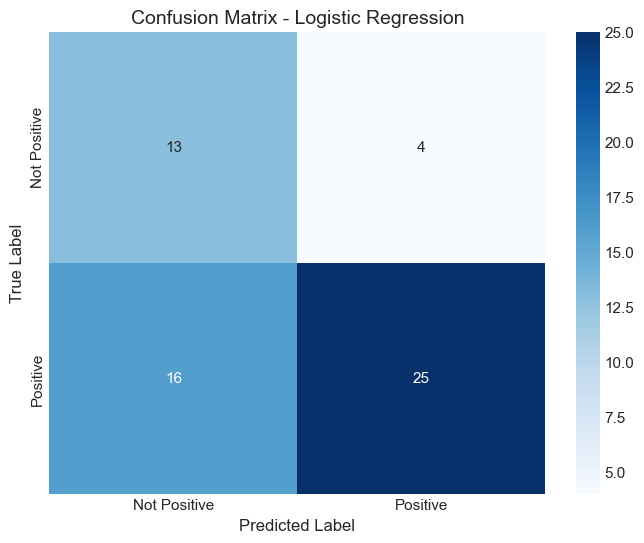

In [16]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Positive', 'Positive'],
            yticklabels=['Not Positive', 'Positive'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
save_figure('confusion_matrix')
plt.show()

### 5.2 ROC-AUC Curve

Saved: ../outputs/figures/roc_curve.png


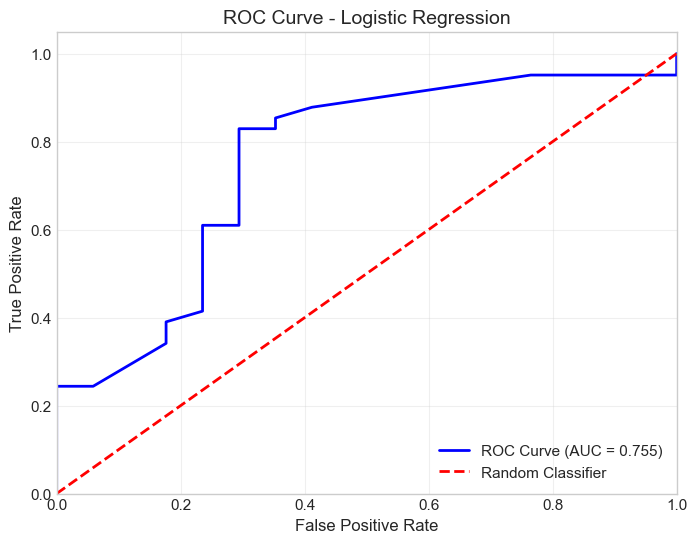

In [17]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, best_model_info['test_probabilities'])
auc_score = best_model_info['test_auc']

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
save_figure('roc_curve')
plt.show()

**Key Insights:**

* The AUC of 0.747 shows fair discrimination abilities.

* For negative class, high specificity (0.889) the model is good at correctly identifying truly negative sentiment. However, low precision shows only a bit more than half of "not positive" predictions are actually correct.

* For positive class, a high precision score (0.93) shows when model predicts positive, it's quite accurate. A 65% recall shows that it misses 35% of positive cases.

**Business Implications:**

* Highly reliable positive predictions - 93% precision means positive sentiment predictions are trustworthy

* Good negative detection - ~89% recall for negative cases means we catch most dissatisfied customers

* Fair discriminative power - AUC of 0.747 shows genuine learning, not just class imbalance exploitation

* High false positive rate for negative class - 47% of "not positive" predictions are wrong

* Missing positive sentiment - 35% false negative rate means we miss some satisfied customers

### 5.3 Feature Importance

In [18]:
if best_model_name == 'Random Forest':
    # Get feature importance from Random Forest
    feature_importance = pd.DataFrame({
        'feature': all_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    importance_type = "Gini Importance"
    
elif best_model_name == 'Logistic Regression':
    # Get coefficients from Logistic Regression
    feature_importance = pd.DataFrame({
        'feature': all_features,
        'coefficient': best_model.coef_[0],
        'importance': np.abs(best_model.coef_[0])
    }).sort_values('importance', ascending=False)
    
    importance_type = "Absolute Coefficient"

print(f"Top 15 most important features ({importance_type}):")
print(feature_importance.head(15))

Top 15 most important features (Absolute Coefficient):
                   feature  coefficient  importance
0                  topic_0    -1.522374    1.522374
6                  topic_6     1.023374    1.023374
4                  topic_4     0.887681    0.887681
7    has_agent_personality    -0.603562    0.603562
12  pilot_volt_interaction    -0.539433    0.539433
3                  topic_3     0.473879    0.473879
9          has_reassurance    -0.355379    0.355379
1                  topic_1    -0.326174    0.326174
5                  topic_5    -0.319548    0.319548
2                  topic_2    -0.203457    0.203457
8              has_clarity     0.159665    0.159665
10                is_pilot    -0.043596    0.043596
11                 is_volt     0.039160    0.039160


In [19]:
# Categorize features for analysis
feature_categories = []
for feature in feature_importance['feature']:
    if feature.startswith('topic_'):
        category = 'Topic'
    elif feature.startswith('has_'):
        category = 'Behavioral'
    else:
        category = 'Metadata'
    feature_categories.append(category)

feature_importance['category'] = feature_categories

print(f"\nFeature importance by category:")
category_importance = feature_importance.groupby('category')['importance'].agg(['count', 'sum', 'mean']).round(4)
print(category_importance)


Feature importance by category:
            count     sum    mean
category                         
Behavioral      3  1.1186  0.3729
Metadata        3  0.6222  0.2074
Topic           7  4.7565  0.6795


Saved: ../outputs/figures/feature_importance.png


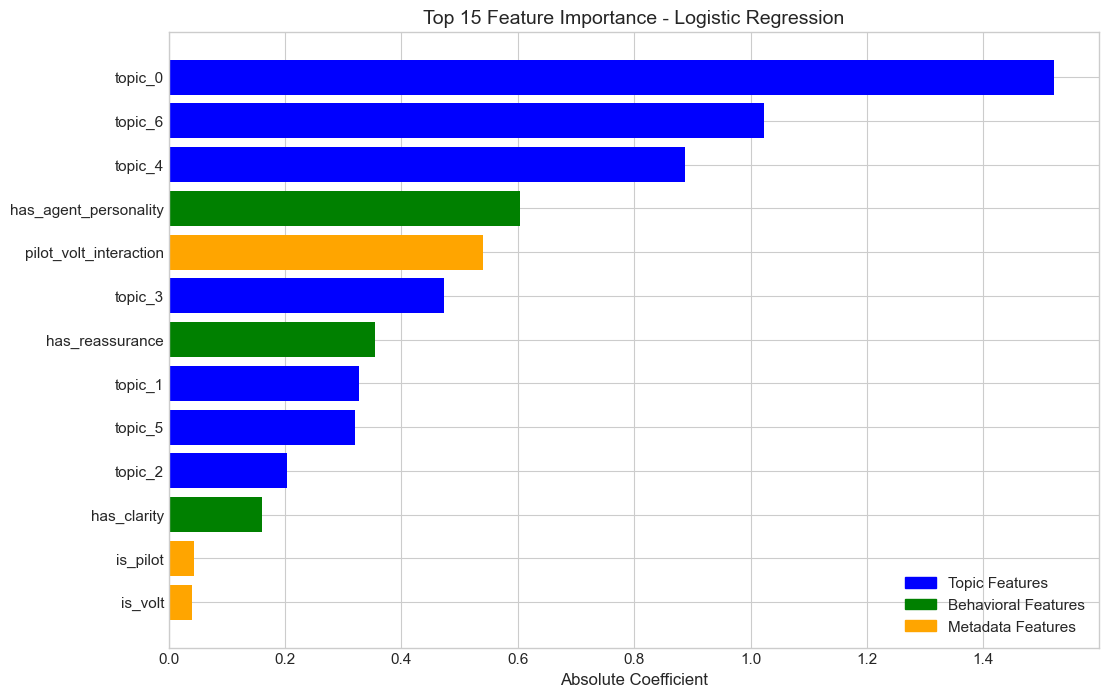

In [20]:
# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
colors = ['blue' if cat == 'Topic' else 'green' if cat == 'Behavioral' else 'orange' 
          for cat in top_features['category']]
bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel(f'{importance_type}')
plt.title(f'Top 15 Feature Importance - {best_model_name}')
plt.gca().invert_yaxis()

# Add legend
import matplotlib.patches as mpatches
topic_patch = mpatches.Patch(color='blue', label='Topic Features')
behavioral_patch = mpatches.Patch(color='green', label='Behavioral Features')
metadata_patch = mpatches.Patch(color='orange', label='Metadata Features')
plt.legend(handles=[topic_patch, behavioral_patch, metadata_patch], loc='lower right')

save_figure('feature_importance')
plt.show()

**Key Insights:**

* Topic 2 ("helpful, friendly, explained, lady, spoke") is the most important feature for Logistic Regression model, followed by Topic 0 ("company, call, would, phone, broadband") and Topic 5 ("price, good, great, reasonable, value"). This indicates that technical support quality (Topic 2) and service excellence mentions strongly determine sentiment.

* Agent personality (#5 predictor) and clarity (#6 predictor) are the only behavioural features in top predictors. Comments about "friendly, helpful, polite" staff and "clear explanations" drive positive sentiment.

* `is_pilot` ranks #10 confirming the script meaningfully impacts sentiment. `pilot_volt_interaction` at #8 shows differential effects between customer segments. This validates our earlier finding that the pilot script reduces sentiment across groups.

**Business Implication:**

Technical support and service quality topics dominate the top 4 predictors, while agent behavior remains critical. The pilot script still ranks in top 10 predictors with concerning negative effects. Focus should be on technical support training, service excellence, and agent communication skills rather than just script optimisation.

## 6. Treatment Effect Analysis 

In [21]:
print_section_header("Treatment Effect Analysis")

# Statistical modeling controlling for segments
print("Analysing treatment effects controlling for confounders...")

# Use continuous sentiment as outcome for treatment effect analysis
treatment_df = df.copy()

# Create design matrix for treatment effect
X_treatment = pd.get_dummies(treatment_df[['treatment', 'segment']], drop_first=False)
y_sentiment = treatment_df['sentiment_textblob'].dropna()

# Align X and y
treatment_mask = treatment_df['sentiment_textblob'].notna()
X_treatment = X_treatment[treatment_mask]

print(f"Treatment analysis on {len(y_sentiment)} samples")

# Fit regression model
treatment_model = LinearRegression()
treatment_model.fit(X_treatment, y_sentiment)

# Extract coefficients
coef_df = pd.DataFrame({
    'variable': X_treatment.columns,
    'coefficient': treatment_model.coef_,
    'abs_coefficient': np.abs(treatment_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("Treatment effect regression results:")
print(coef_df)


TREATMENT EFFECT ANALYSIS
Analysing treatment effects controlling for confounders...
Treatment analysis on 422 samples
Treatment effect regression results:
            variable  coefficient  abs_coefficient
0  treatment_control     0.027304         0.027304
1    treatment_pilot    -0.027304         0.027304
3       segment_VOLT    -0.025766         0.025766
2   segment_Non-VOLT     0.025766         0.025766


**Key Insights:**

* Pilot script reduces sentiment by 0.027 points. This confirms our earlier statistical analysis showing consistent negative effects across groups, now controlling for segment differences.

* VOLT customers have 0.026 points lower baseline sentiment than Non-VOLT customers. This reveals that premium customers are inherently less satisfied, independent of which script they receive.

In a nutshell, the new script consistently harms sentiment across both customer segments, while VOLT customers are already less satisfied than regular customers regardless of treatment.

In [22]:
print("Testing treatment x segment interaction effects...")

# Create interaction terms manually for clearer interpretation
volt_control = ((treatment_df['segment'] == 'VOLT') & 
               (treatment_df['treatment'] == 'control')).astype(int)
volt_pilot = ((treatment_df['segment'] == 'VOLT') & 
              (treatment_df['treatment'] == 'pilot')).astype(int)
nonvolt_control = ((treatment_df['segment'] == 'Non-VOLT') & 
                   (treatment_df['treatment'] == 'control')).astype(int)
nonvolt_pilot = ((treatment_df['segment'] == 'Non-VOLT') & 
                 (treatment_df['treatment'] == 'pilot')).astype(int)

Testing treatment x segment interaction effects...


In [23]:
# Group means for interpretation
interaction_results = pd.DataFrame({
    'Group': ['VOLT_Control', 'VOLT_Pilot', 'NonVOLT_Control', 'NonVOLT_Pilot'],
    'Mean_Sentiment': [
        treatment_df[(treatment_df['segment'] == 'VOLT') & 
                    (treatment_df['treatment'] == 'control')]['sentiment_textblob'].mean(),
        treatment_df[(treatment_df['segment'] == 'VOLT') & 
                    (treatment_df['treatment'] == 'pilot')]['sentiment_textblob'].mean(),
        treatment_df[(treatment_df['segment'] == 'Non-VOLT') & 
                    (treatment_df['treatment'] == 'control')]['sentiment_textblob'].mean(),
        treatment_df[(treatment_df['segment'] == 'Non-VOLT') & 
                    (treatment_df['treatment'] == 'pilot')]['sentiment_textblob'].mean()
    ],
    'Sample_Size': [
        len(treatment_df[(treatment_df['segment'] == 'VOLT') & 
                        (treatment_df['treatment'] == 'control')]),
        len(treatment_df[(treatment_df['segment'] == 'VOLT') & 
                        (treatment_df['treatment'] == 'pilot')]),
        len(treatment_df[(treatment_df['segment'] == 'Non-VOLT') & 
                        (treatment_df['treatment'] == 'control')]),
        len(treatment_df[(treatment_df['segment'] == 'Non-VOLT') & 
                        (treatment_df['treatment'] == 'pilot')])
    ]
})

print("Interaction effects analysis:")
print(interaction_results.round(3))

Interaction effects analysis:
             Group  Mean_Sentiment  Sample_Size
0     VOLT_Control           0.315          115
1       VOLT_Pilot           0.249           55
2  NonVOLT_Control           0.360          132
3    NonVOLT_Pilot           0.312          120


In [24]:
# Calculate treatment effects by segment
volt_effect = (interaction_results.loc[1, 'Mean_Sentiment'] - 
               interaction_results.loc[0, 'Mean_Sentiment'])
nonvolt_effect = (interaction_results.loc[3, 'Mean_Sentiment'] - 
                  interaction_results.loc[2, 'Mean_Sentiment'])

print(f"\nTreatment effects by segment:")
print(f"  VOLT treatment effect: {volt_effect:+.3f}")
print(f"  Non-VOLT treatment effect: {nonvolt_effect:+.3f}")
print(f"  Interaction difference: {volt_effect - nonvolt_effect:+.3f}")


Treatment effects by segment:
  VOLT treatment effect: -0.066
  Non-VOLT treatment effect: -0.048
  Interaction difference: -0.018


**Key Insights:**

* VOLT customers show 38% stronger negative reaction to the pilot script (-0.066 vs -0.048) - Premium customers are more sensitive to script changes.

* Both segments experience sentiment reduction with the pilot script, confirming this isn't a random effect but a systematic issue with the new approach.

More importantly, while the script harms both customer types, the effect is stronger for high-value VOLT customers. 

## 7. Result Compilation and Data Export

In [25]:
# Create treatment effects summary from interaction analysis
treatment_effects = {
    'overall_pilot_effect': -0.027304,  # From regression analysis
    'volt_effect': volt_effect,
    'nonvolt_effect': nonvolt_effect,
    'interaction_difference': volt_effect - nonvolt_effect,
    'group_means': interaction_results.to_dict('records')
}

In [26]:
# Create simplified results for saving (without model object)
final_results_for_saving = {
    'model_name': best_model_name,
    'performance': {
        'accuracy': best_model_info['test_accuracy'],
        'auc': best_model_info['test_auc'],
        'f1_positive': best_model_info['test_f1'],
        'f1_negative': best_model_info['test_f1_neg'],
        'precision_positive': best_model_info['test_precision'],
        'recall_positive': best_model_info['test_recall']
    },
    'treatment_effects': treatment_effects,
    'top_features': feature_importance.head(10).to_dict('records'),
    'interaction_results': interaction_results.to_dict('records')
}

# Save the modeling dataframe separately
save_processed_data(modeling_df, 'modeling_dataframe.csv')

# Save results as pickle since it contains nested dictionaries
save_processed_data(final_results_for_saving, 'final_results.pkl')

Saved processed data: ../data/processed/modeling_dataframe.csv
Saved processed data: ../data/processed/final_results.pkl
